<a href="https://colab.research.google.com/github/nyp-sit/it3103/blob/main/week3/multi_class_image_classification_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Exercise: Multi-class Image Classification

Now that you have learnt how to train a model to do binary image classification of cats and dogs using Convolutional Neural Network. 

Modify the code to train a model to recognise whether a hand gesture is one of the gesture in the rock, paper and scissor game. 

The dataset of rock paper scissor can be downloaded from https://nypai.s3-ap-southeast-1.amazonaws.com/datasets/rps2.zip

### Step 1: Import the necessary packages

In [1]:
import os 
import tensorflow as tf
import tensorflow.keras as keras

### Step 2: Download Datasets

Download the dataset and unzip the file to a folder.

In [3]:
dataset_URL = 'https://nypai.s3-ap-southeast-1.amazonaws.com/datasets/rps2.zip'
path_to_zip = tf.keras.utils.get_file('rps2.zip', origin=dataset_URL, extract=True, cache_dir='.')
print(path_to_zip)
dataset_dir = os.path.join(os.path.dirname(path_to_zip), 'rps2')


./datasets/rps2.zip


In [4]:
print(dataset_dir)

./datasets/rps2


### Step 3: Set up your directory. 

Examine your dataset folder and set your dataset directory to point to the correct directories.

In [6]:
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")

### Step 4: Set up the  tf.keras.preprocessing.image_dataset_from_directory()

Set up the  tf.keras.preprocessing.image_dataset_from_directory() for both train and validation set.

In [23]:
img_height, img_width = 128, 128
batch_size = 32

# resize all the images to the same size as expected by VGG model we downloaded above
image_size = (img_height, img_width)

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


In [24]:
for images, labels in train_ds.take(1):
    print('images shape:', images.shape)
    print('labels shape:', labels.shape)
    print(tf.squeeze(labels))

images shape: (32, 128, 128, 3)
labels shape: (32,)
tf.Tensor([1 1 1 0 1 0 0 1 2 2 1 0 1 0 1 2 0 2 0 2 0 1 2 2 0 1 0 2 1 2 2 2], shape=(32,), dtype=int32)


You can see the labels is **NOT** one-hot-encoded.  Try changing the class_mode to 'categorical' and observe that the label will be one-hot-encoded.

Print out the class indices so that you know what label is assigned to which class.  Hint: use ``class_names`` of the generator.

In [25]:
## print out the class indices
print(train_ds.class_names)
print(val_ds.class_names)

['paper', 'rock', 'scissors']
['paper', 'rock', 'scissors']


### Step 5: Create your model

In [28]:
def make_model():

    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(128, 128, 3)))
    model.add(keras.layers.Rescaling(scale=1./255))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))

    return model

model = make_model()

### Step 6: Compile and Train the Model

Make sure you choose the correct loss function. 

In [29]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])


Visualize your training using Tensorboard.

In [30]:
def create_tb_callback(): 

    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run
	    import time
	    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
	    return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="bestcheckpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[create_tb_callback(), model_checkpoint_callback])


Epoch 1/30
79/79 [==============================] - 67s 838ms/step - loss: 0.8072 - accuracy: 0.6413 - val_loss: 0.7832 - val_accuracy: 0.5968
Epoch 2/30
79/79 [==============================] - 9s 103ms/step - loss: 0.1319 - accuracy: 0.9718 - val_loss: 0.2582 - val_accuracy: 0.9516
Epoch 3/30
79/79 [==============================] - 9s 102ms/step - loss: 0.0267 - accuracy: 0.9952 - val_loss: 0.2336 - val_accuracy: 0.9328
Epoch 4/30
79/79 [==============================] - 8s 99ms/step - loss: 0.0109 - accuracy: 0.9980 - val_loss: 0.2536 - val_accuracy: 0.9220
Epoch 5/30
79/79 [==============================] - 8s 98ms/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 0.2417 - val_accuracy: 0.9462
Epoch 6/30
79/79 [==============================] - 8s 98ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2413 - val_accuracy: 0.9382
Epoch 7/30


KeyboardInterrupt: ignored

### Step 7: Save your Model

Save your model for use in inference later on.

In [33]:
keras.models.save_model(model, filepath="rps_model")

INFO:tensorflow:Assets written to: rps_model/assets


### Test your model

The following code cells shows you how to set up Google Colab to take a picture using your webcam. Take a picture of your hand gesture (rock, paper or scissors) and infer using your saved model.

In [34]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


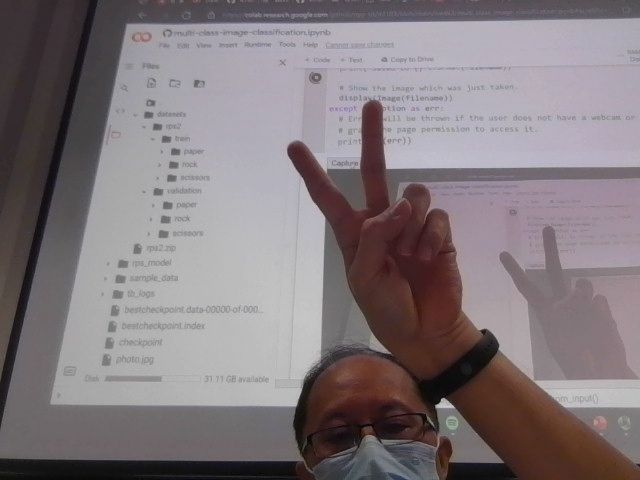

In [41]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Write code to read the image and reshape the tensor (to include batch axis) and use your model to predict the label.

In [43]:
import numpy as np

img = keras.preprocessing.image.load_img(
    filename, target_size=(128, 128)
)

# we convert the image to numpy array
img_array = keras.preprocessing.image.img_to_array(img)

# Although we only have single image, however our model expected data in batches
# so we will need to add in the batch axis too
img_array = tf.expand_dims(img_array, 0) # Create a batch

# we load the model saved earlier and do the inference 
model = tf.keras.models.load_model('rps_model')
predicted_label = model.predict(img_array)
# or predicted_label = model(img_array)

print(np.argmax(predicted_label))

1


In [40]:
val_ds.class_names

['paper', 'rock', 'scissors']